## Importing modules

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm.notebook import trange, tqdm

In [2]:
from utils.dataset import ClimateHackDataset
from utils.loss import MS_SSIMLoss
from utils.utils import *
from utils.lr_finder import LRFinder
from config import config, results_config

from submission.model import Model
from submission.unet import UNet
from submission.conv_lstm import EncoderDecoderConvLSTM
from submission.ConvLSTM2 import ConvLSTM

In [3]:
device = torch.device(config['device'])
create_files(results_config.values())
save_logs(config, config['logs_path'])
device

device(type='cuda', index=0)

#### Dataloader

In [4]:
dataset = xr.open_dataset(
    config['data_path'],
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)

In [5]:
ch_dataset = ClimateHackDataset(dataset, crops_per_slice=1, day_limit=100)

with open('D:\\climate_hack\\dataset.obj', 'rb') as file:
    ch_dataset.cached_items = pickle.load(file)

ch_dataloader = DataLoader(ch_dataset, batch_size=config['batch_size'])

### Instantiating the model

In [6]:
# model = UNet(in_channels=12, out_channels=24, dim=2).to(device)
# model = EncoderDecoderConvLSTM(nf=32, encoder_channels=32).to(device)
# model = EncoderDecoderConvLSTM(nf=8).to(device)
# model = Model().to(device)
# model = ConvLSTM().to(device)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
criterion = MS_SSIMLoss(channels=24) # produces less blurry images than nn.MSELoss()
# criterion = nn.MSELoss()

In [8]:
# lr_finder = LRFinder(model, optimizer, criterion)
# lr_finder.range_test(ch_dataloader, end_lr=1, num_iter=500, start_lr=1e-6)
# lr_finder.plot()

In [9]:
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], epochs=config['num_epochs'], steps_per_epoch=(len(ch_dataset.cached_items)//config['batch_size'] + 1))

In [10]:
writer = SummaryWriter(config['tensorboard_path'])

In [11]:
# model.load_state_dict(torch.load('submission/model.pt'))

### Training the model

In [12]:
model = model.train()

In [13]:
train_batch = 0

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

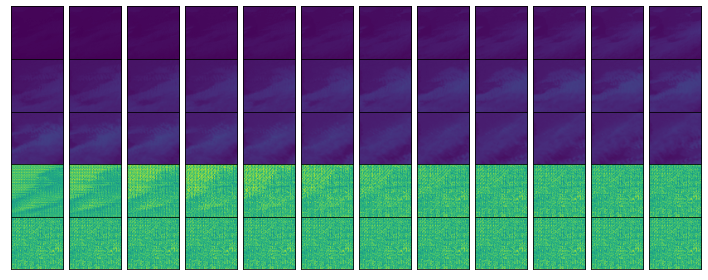

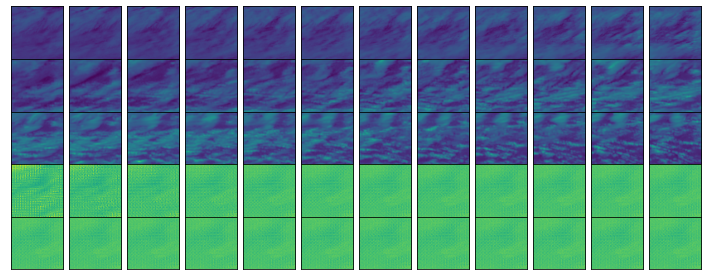

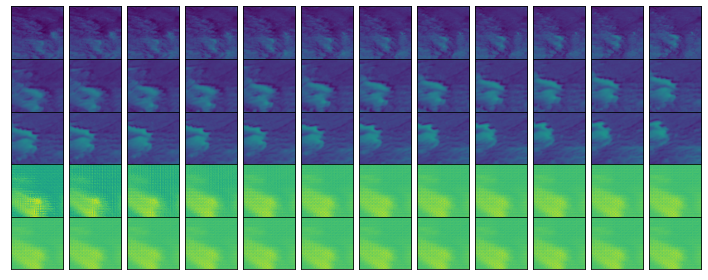

0.3233422164333285


0it [00:00, ?it/s]

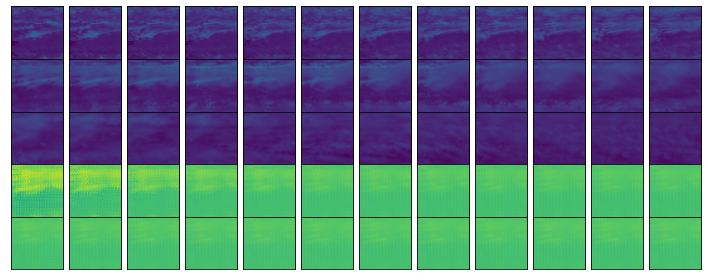

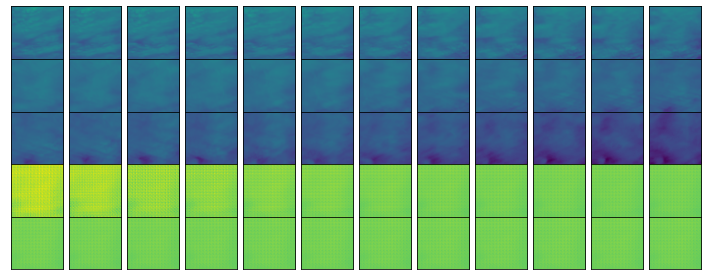

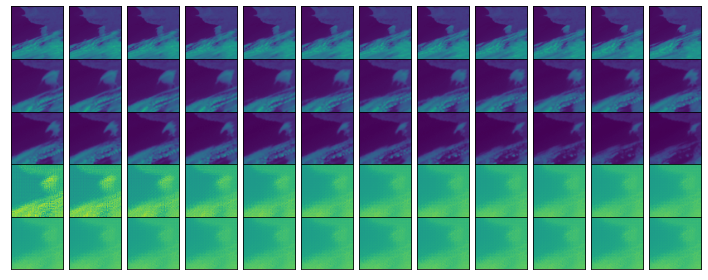

0.29098755142690896


0it [00:00, ?it/s]

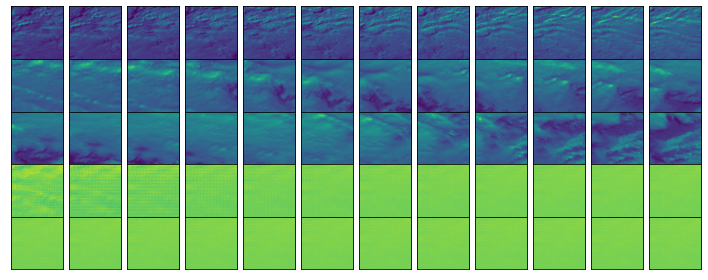

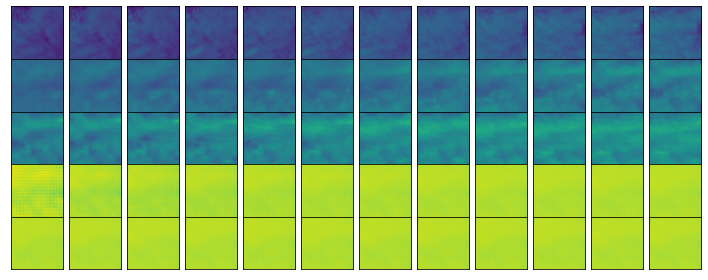

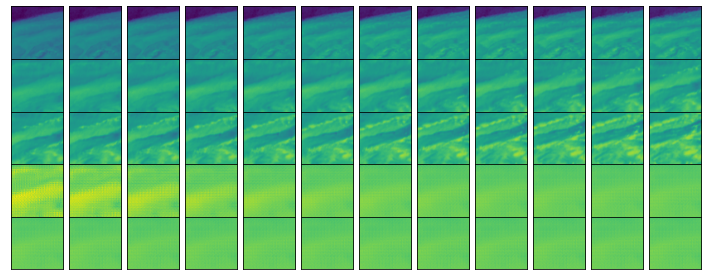

0.2823771053772591


0it [00:00, ?it/s]

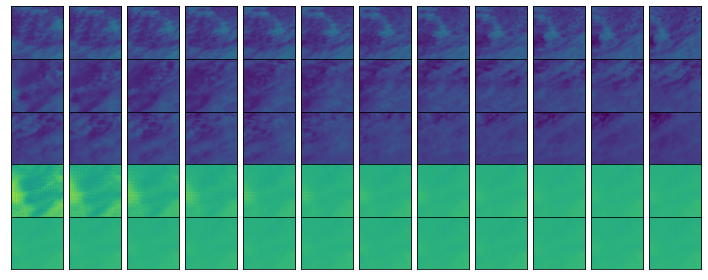

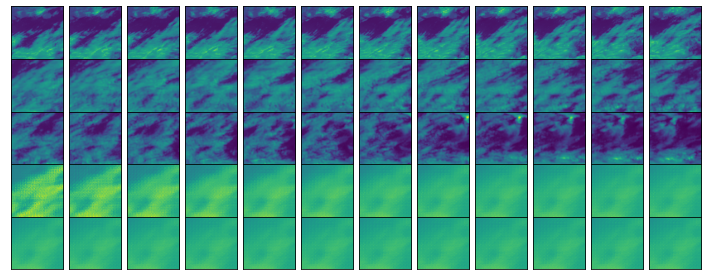

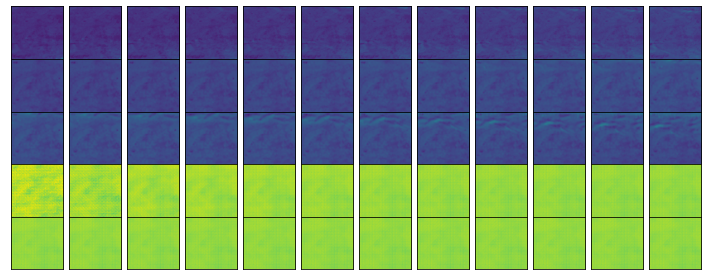

0.2733573952738387


0it [00:00, ?it/s]

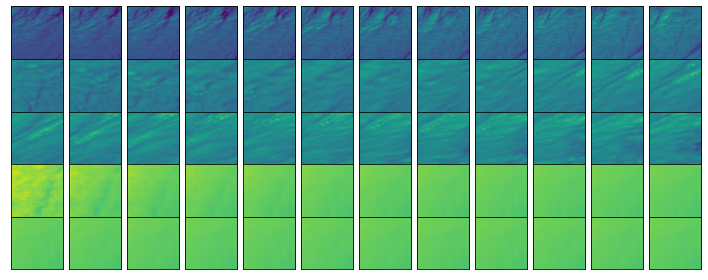

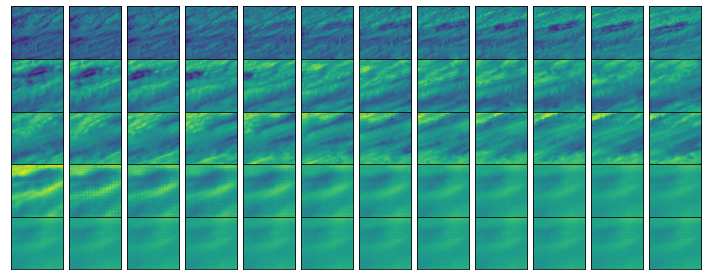

0.2611047707625491


0it [00:00, ?it/s]

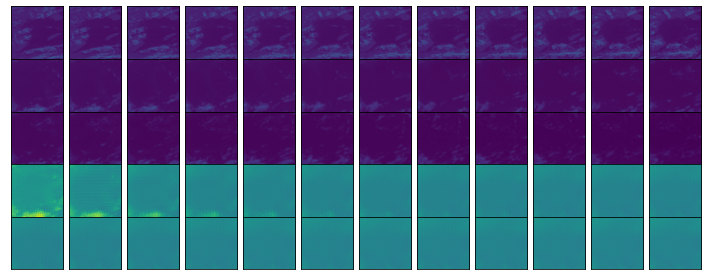

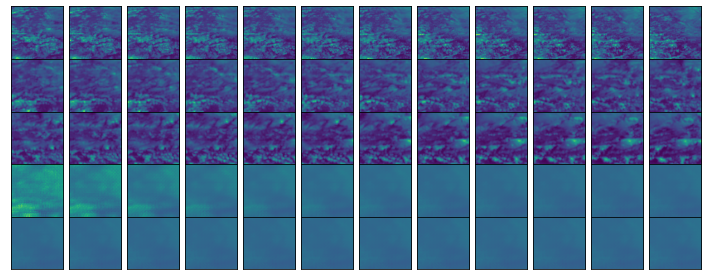

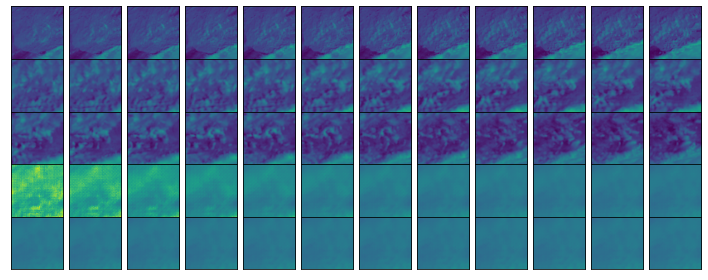

0.24380298630811414


0it [00:00, ?it/s]

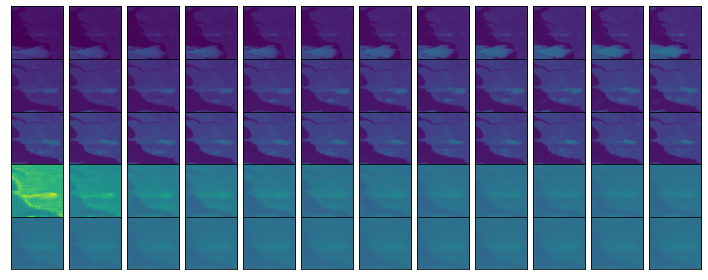

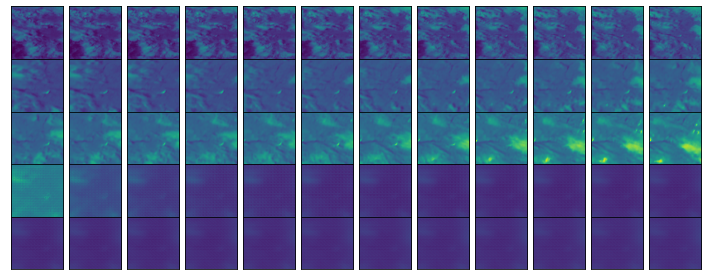

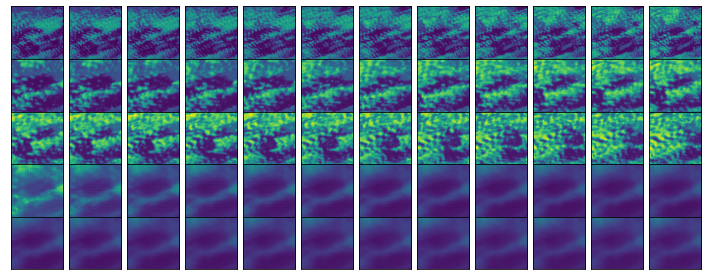

0.23067273651555678


0it [00:00, ?it/s]

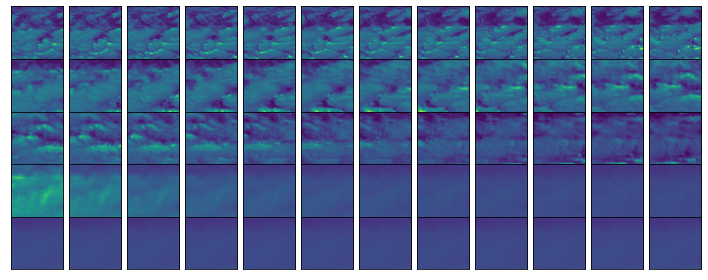

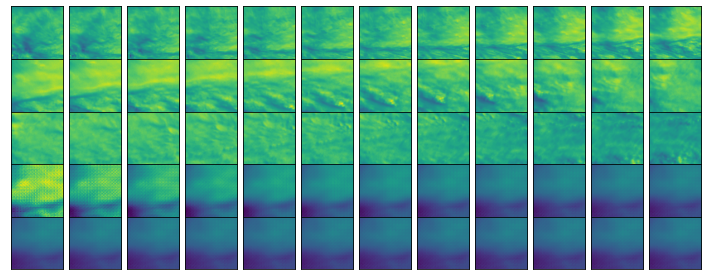

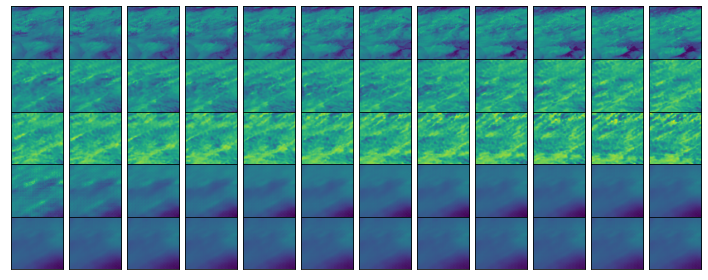

0.2250739370349503


0it [00:00, ?it/s]

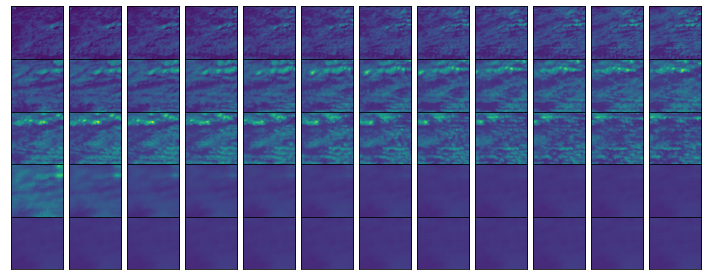

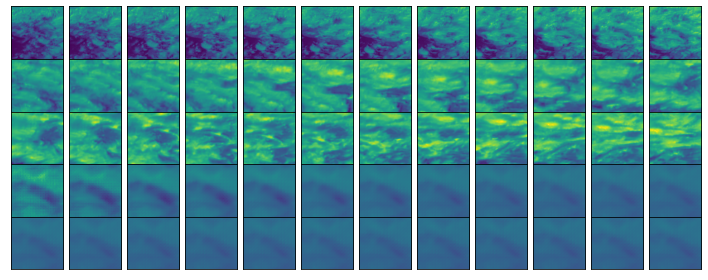

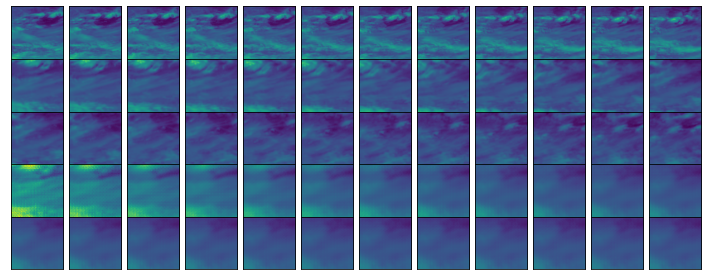

0.2223813640545554


0it [00:00, ?it/s]

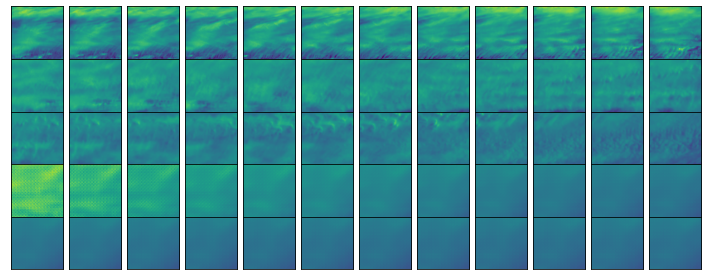

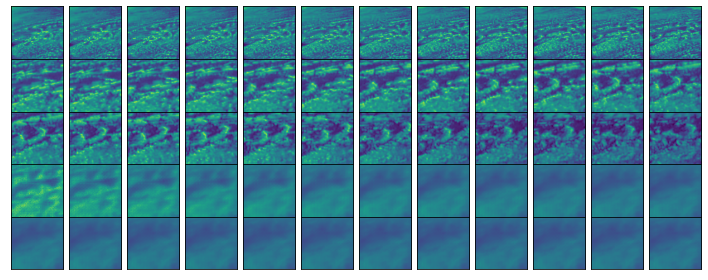

0.21756925221287807


0it [00:00, ?it/s]

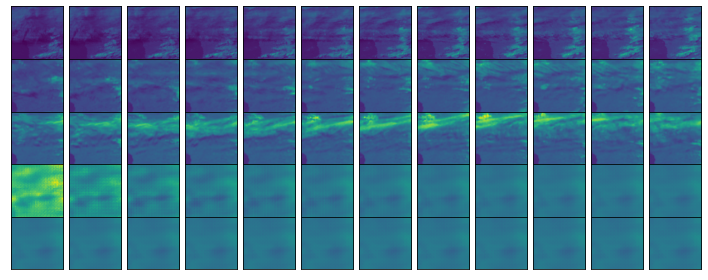

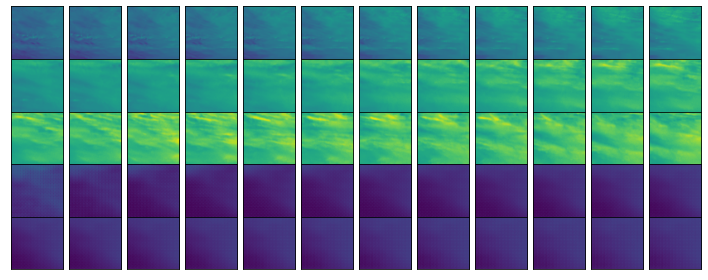

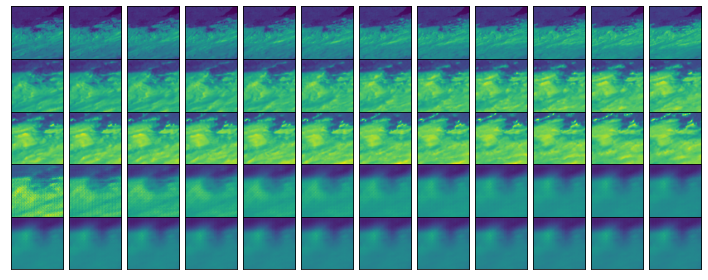

0.21443896503946355


0it [00:00, ?it/s]

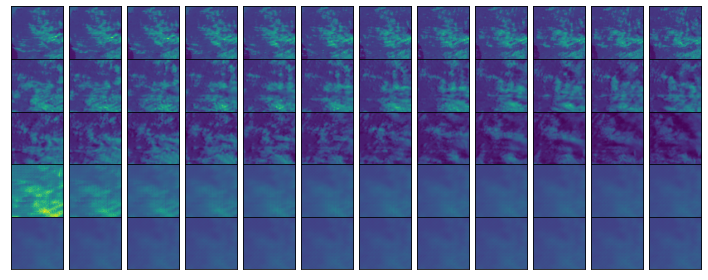

KeyboardInterrupt: 

In [14]:
for epoch in trange(config['num_epochs']):
    running_loss = 0
    count = 0
    for inputs, target in tqdm(ch_dataloader):
        inputs = inputs.to(device)
        target = target.to(device)
        
        # clear gradients
        optimizer.zero_grad()
        
        # forward
        output = model(inputs.to(device) / 1024.0)
        assert output.min() > 1 and output.max() <= 1024
        assert target.min() > 1 and target.max() <= 1024
        batch_loss = criterion(output, target)
        
        # compute gradients
        batch_loss.backward()
        
        # update weights
        optimizer.step()
        
        # update stats
        running_loss += batch_loss.item() * output.shape[0]
        count += output.shape[0]

        # writer.add_scalar('Train/loss', batch_loss.item(), train_batch)
        writer.add_scalar('Train/lr', get_lr(optimizer), train_batch)
        
        if train_batch % 50 == 0:
            plot_preds(inputs.squeeze().detach().cpu().numpy()[0],
                       target.squeeze().detach().cpu().numpy()[0] ,
                       output.detach().cpu().numpy()[0])
            
        train_batch += 1
        
        # scheduler.step()

        del inputs, target, output, batch_loss
    print(running_loss/count)
    writer.add_scalar('Train/loss', running_loss/count, epoch)

    save_model(epoch, model, optimizer, config['checkpoints_path'])
    # print(f"Loss for epoch {epoch + 1}/{EPOCHS}: {losses[-1]}")

### Visualising predictions

Having trained the model, it is often useful to visualise some of its predictions to ensure it is producing a sensible output.

In [ ]:
config['checkpoints_path']

In [40]:
# model.load_state_dict(torch.load('D:/climate_hack/results/conv_lstm_2d-decoder_mse/checkpoints/4.pt')['state_dict'])
model.load_state_dict(torch.load(config['checkpoints_path'] + '/7.pt')['state_dict'])

<All keys matched successfully>

torch.Size([1, 12, 1, 128, 128])


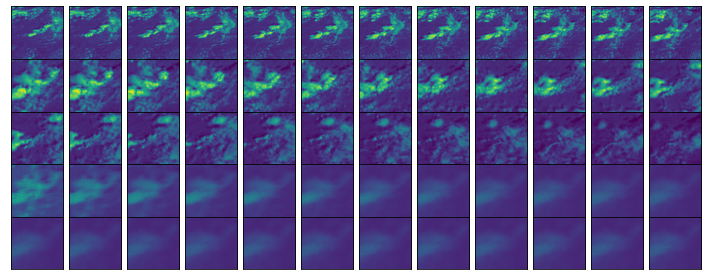

In [41]:
x = dataset["data"].sel(time=slice("2020-07-01 12:00", "2020-07-01 12:55")).isel(x=slice(128, 256), y=slice(128, 256)).to_numpy()
y = dataset["data"].sel(time=slice("2020-07-01 13:00", "2020-07-01 14:55")).isel(x=slice(160, 224), y=slice(160, 224)).to_numpy()
x_ = torch.from_numpy(x.astype(np.float32)).to(device).view(1, 12, 1, 128, 128) / 1023
print(x_.shape)
p = model(x_).detach().squeeze().cpu().numpy()
# p = p * 1023.0

plot_preds(x, y, p)

In [42]:
criterion(torch.Tensor(p).to(device).unsqueeze(0), torch.Tensor(y).to(device).unsqueeze(0))

tensor(0.6384, device='cuda:0')

In [43]:
state_dict = model.state_dict()
    
for key in state_dict.keys():
    state_dict[key] = state_dict[key].cpu()

In [44]:
torch.save(state_dict, 'submission/model.pt')

In [45]:
model

ConvLSTM(
  (encoder): Encoder(
    (conv_0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (convlstm_1): ConvLSTMBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (conv_2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (convlstm_3): ConvLSTMBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(

In [28]:
# with open('D:\\climate_hack\\dataset.obj', 'wb') as file:
#     pickle.dump(ch_dataset.cached_items, file)

#### Submitting the model to DOXA
```bash
$ python doxa_cli.py user login
```
```bash
$ python doxa_cli.py agent upload climatehack ./submission
```